In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data(tkwargs)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble.cuda();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


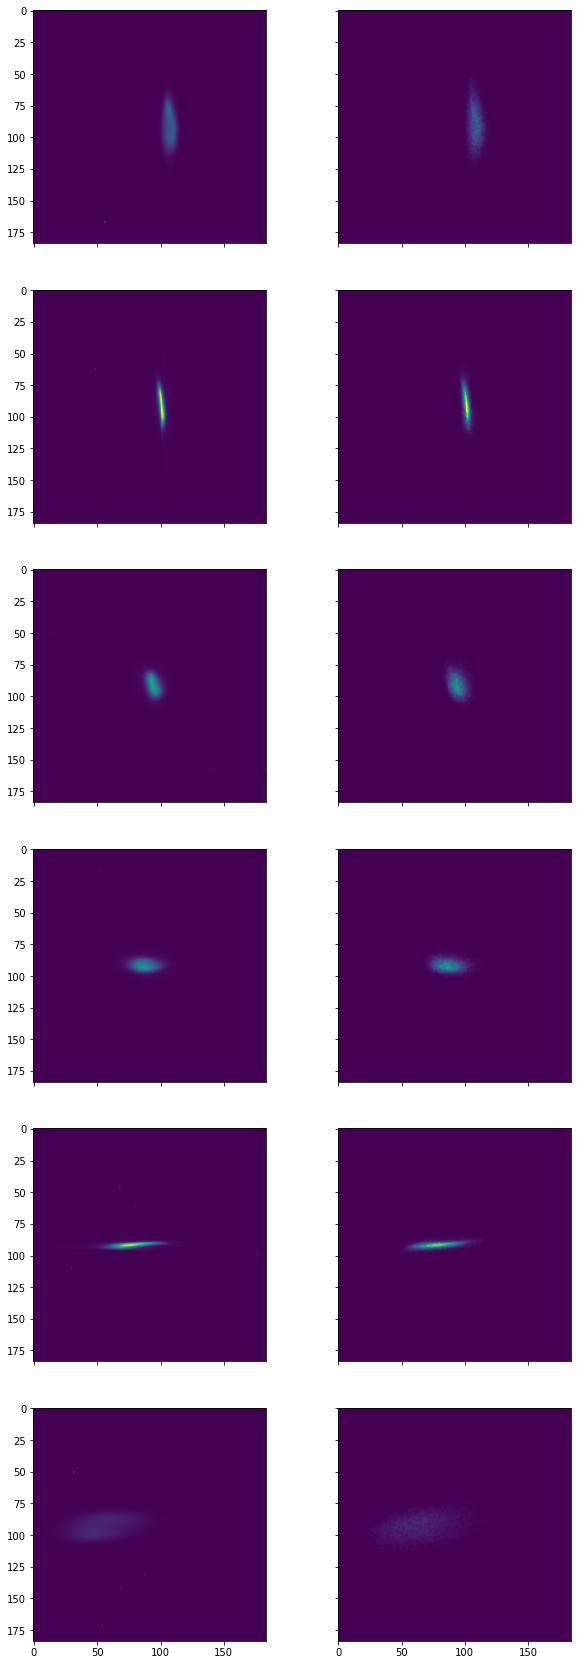

In [2]:
s = torch.arange(0,11,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](train_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].imshow(train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].imshow(predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

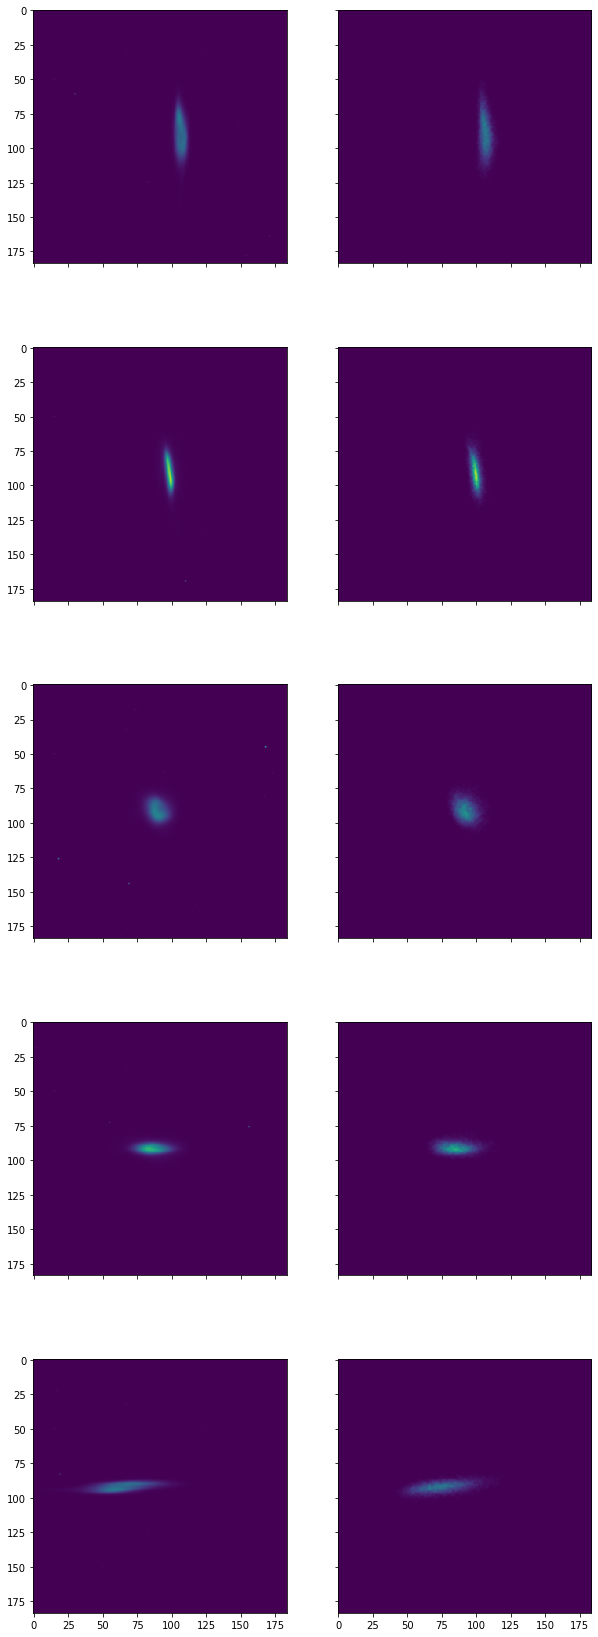

In [3]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](test_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].imshow(test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.01
                    )
    ax[i][1].imshow(predictions[i][0].cpu().detach(), vmin=0,vmax=0.01)

In [4]:
# plot loss record
loss = torch.stack(torch.load(save_dir + "/loss_log.pt"))

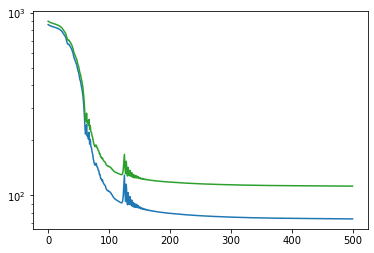

In [5]:
plt.semilogy(loss)

In [6]:
initial_beam = ensemble[0].beam()

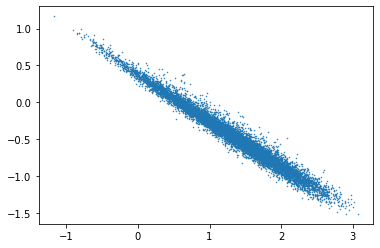

In [7]:
fig,ax=plt.subplots()
ax.plot(
    initial_beam.y.cpu().detach()*1e3,
    initial_beam.py.cpu().detach()*1e3,
    '.',ms=1
)

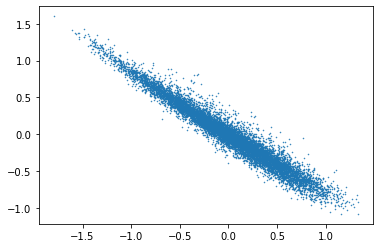

In [8]:
fig,ax=plt.subplots()
y_screen = initial_beam.y.cpu().detach()*1e3 + initial_beam.py.cpu().detach()*1e3*(3.38-0.12-2.84)
yp_screen = initial_beam.py.cpu().detach()*1e3
ax.plot(
    y_screen - y_screen.mean(), yp_screen - yp_screen.mean(),
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

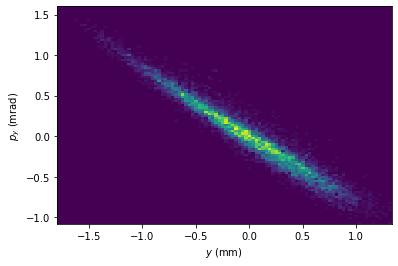

In [9]:
fig,ax=plt.subplots()
y_slits = initial_beam.y.cpu().detach()*1e3 + initial_beam.py.cpu().detach()*1e3*(
    3.38-0.12-2.84
)
yp_slits = initial_beam.py.cpu().detach()*1e3
ax.hist2d(
    (y_slits - y_slits.mean()).numpy(),
    (yp_slits - yp_slits.mean()).numpy(), bins=100
);
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

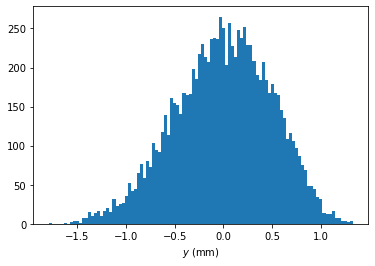

In [10]:
fig,ax=plt.subplots()
y_slits = initial_beam.y.cpu().detach()*1e3 + initial_beam.py.cpu().detach()*1e3*(
    3.38-0.12-2.84
)
yp_slits = initial_beam.py.cpu().detach()*1e3
ax.hist(
    (y_slits - y_slits.mean()).numpy(), bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

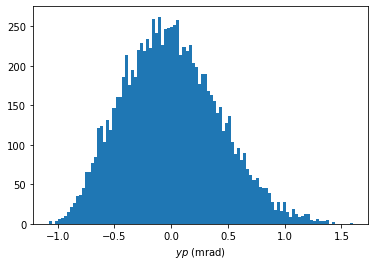

In [11]:
fig,ax=plt.subplots()
y_slits = initial_beam.y.cpu().detach()*1e3 + initial_beam.py.cpu().detach()*1e3*(
    3.38-0.12-2.84
)
yp_slits = initial_beam.py.cpu().detach()*1e3
ax.hist(
    (yp_slits - yp_slits.mean()).numpy(), bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [12]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 4.0553e-07, -2.3602e-07,  9.6094e-08, -8.1442e-08,  1.0558e-06,
          8.5330e-08],
        [-2.3602e-07,  1.4161e-07, -3.9334e-08,  3.6425e-08, -5.7606e-07,
         -3.7357e-08],
        [ 9.6094e-08, -3.9334e-08,  4.4837e-07, -2.7810e-07,  1.2166e-06,
         -3.6880e-08],
        [-8.1442e-08,  3.6425e-08, -2.7810e-07,  1.7747e-07, -7.9921e-07,
          3.3406e-09],
        [ 1.0558e-06, -5.7606e-07,  1.2166e-06, -7.9921e-07,  1.0346e-05,
          1.9036e-06],
        [ 8.5330e-08, -3.7357e-08, -3.6880e-08,  3.3406e-09,  1.9036e-06,
          4.2911e-06]], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [13]:
ycov = cov[2:4,2:4]

In [14]:
ycov

tensor([[ 4.4837e-07, -2.7810e-07],
        [-2.7810e-07,  1.7747e-07]], device='cuda:0', grad_fn=<SliceBackward0>)

In [15]:
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 4.723258939520747e-08
beta 9.492857933044434
alpha 5.887925624847412
gamma 3.7573161125183105


In [16]:
# geometric emittance
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63/0.511}")

geo_emit: 4.723258939520747e-08
norm emit: 5.823196261189878e-06
